# Localized coupling and symmetry in a simulated network of the inferior olive of a mouse

## Project description
In this project, I tried to uncover the dynamics of the very local interactions between different neighbouring neurons when only one of them is spiked with an AMPA spike, inputted at the center of the neuron (soma). As you will follow ahead, I try to briefly explain what I did and why it is of importance. If you follow along this code, you will likely be able to reproduce the figures and data I obtained during the analysis of the network.

## Brief network description
For this network, the simulation, and parameters please refer to Lennart Landsmeer's code, work, and article for a very detailed description. The model is build on Arbor, which is a package that can be tuned in such a detailed way, that it is possible to build a highly realistic multi-compartmental model. 3 Dimensional cable cells are simulated having a soma, stochastically generated dendritic arms that can branch, and a terminal axon as well. A couple of things are important to understand, such as how the cells are labeled and the dynamics are specified of all cells. For this, detailed descriptions can be found in the Arbor documentation (https://docs.arbor-sim.org/en/latest/index.html) and should be read before running the codeblocks below as to better understand the complete network ( something I didn't start doing, which I regretted in the end... :) ). 

## Brief introduction to IO function
The inferior olivary (IO) nucleus operates as a key component in a larger functioning network. Its climbing fibres (CFs) are directly linked to the Purkinje cells in the cerebellar cortex as well as CF collaterals to the cerebellar nuclei; see the circuit in Figure 1. The IO’s activity has been established through various studies and is directly involved in the temporal accuracy of motor behaviour, and additionally perceptual function and motor learning. How synchronization of electrotonically coupled neurons in the IO through gap junction currents after initial input occurs, is not completely understood. However, it has been shown that after $GABA_A$ receptor blocking, the number of in-phase oscillating neurons in the IO increased, suggesting a rise in the amount of electrotonically coupled neurons. This was also observed in a similar experimental set-up in Purkinje cells [3]. To completely grasp this dynamic process, one may consider the local field potentials in an experiment or simulation to enlighten the large-scale dynamics of the network and to infer the clustering coefficients important for the synchronization of the sub-threshold oscillations that IO cells possess.

## General aim 
However, initial understanding may come from comprehending in what way the immediate neighbours of a coupled neuron interact with it, on a highly local scale. Therefore, in this report the local interactions of directly coupled neurons were considered in a simulated inferior olive mouse network to learn about these interactions and potentially deduce information on the larger dynamics of the system. In order to do so, highly local perturbations were simulated using single-spike AMPA inputs, targeting the soma of a single randomly targeted neuron. Only one perturbation per simulation was instigated, to exclude any potential influence of other localized perturbations. Then, bi-directional analysis of directly coupled neurons was performed using coupling coefficients
of target (T) to neighbour (N) ($CC_1$/$CC_{T>N}$) and neighbour to target ($CC_2$/$CC_{N>T}$).

## Importing all libraries of importance

In [37]:
%matplotlib inline


# if you want a specific arbor load location after a custom cmake build
# from https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path

#Import all important packages and libraries
import sys
import importlib
ARBOR_LOCATION = '/home/lennart/Repos/arbor-sim/arbor/build/python/arbor/__init__.py'
spec = importlib.util.spec_from_file_location('arbor', ARBOR_LOCATION)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

import random
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import dcor

import scipy
from scipy import stats
from scipy import signal
from scipy.stats import pearsonr

import arbor

import pandas as pd

import pickle

import h5py

import iopublic
iopublic.ARBOR_BUILD_CATALOGUE = '/home/lennart/Repos/arbor-sim/arbor/build/arbor-build-catalogue'

# Simulation loop

## Simulation per different UGJC tuning

Here we start with the defining of the particularly tuned network we want to eventually analyze. For this analysis, we will first spike one of the 973 neurons in the network at random with an AMPA spike. We will collect that data and store it in the first part of our dictionary. Then, we will spike all neighbours of this initially randomly spiked neuron. We will do this in n = # neighbours different simulations, to make sure the spiking of a neighbour does not influence the $V_s$ of another neighbour. We collect all this data and store it into a single dictionary, which we save in the end.


In [ ]:
%%time

#Choose network of interest for analyzing
selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
network = iopublic.get_network_for_tuning(selected)

#Variables for radius of spike and weight. r can be chosen larger if you don't use AMPA spike but GABA.
#Otherwise, use r = 1 as the spike should only be very local on target neuron.
r = 1 #um
weight = 0.005 #uS


#For our simulation, initially 40 random targets were selected. To keep these targets similar for differently tuned network
#I saved them and load them into the variable here.
with open('rand_target40.pickle', 'rb') as handle:
    rand_target40 = pickle.load(handle)

# A small function for the definition of a spike and how it should be put into the simulation.    
def spikes_for_gid(gid):
    return {4000: (network.neurons[gid].x,
                   network.neurons[gid].y,
                   network.neurons[gid].z,
                   r, weight, 'ampa')}

# Creating a dictionary to store all the variables of the simulations in.
vs_dict_target = {}

# Main loop of the simulation
for spike_target_gid in rand_target40:
    #Mapping of id's for tracing of neighbours
    idmap = {neuron.old_id:new_id for new_id, neuron in enumerate(network.neurons)}
    neighbours = [idmap[trace.global_to] for trace in network.neurons[spike_target_gid].traces]
    
    print('running sim for', spike_target_gid)
    
    #Getting the time and V_s data of the simulation for the initial target
    t_ampa, vs_ampa = iopublic.simulate_tuned_network(selected, tfinal=4200, dt=0.025, gpu_id=0, 
                                        spikes=spikes_for_gid(spike_target_gid))
    
    #Creating another dictionary for neighbour V_s data
    vs_dict_neighbour = {}
    
    #Nested for-loop for V_s data when all of the neighbours of the initial target are (one by one) spiked. 
    for gid_neighbour in neighbours:
        print('running neighbour sim for', gid_neighbour)
        
        _, vs_ampa_N = iopublic.simulate_tuned_network(selected, tfinal=4200, dt=0.025, gpu_id=0, 
                                        spikes=spikes_for_gid(gid_neighbour))
        vs_dict_neighbour[gid_neighbour] = vs_ampa_N
                                                      
    #Saving all necessary information into the initial dictionary, sorted per initial target
    #Format dict: Initial target # : V_s : neighbours : neighbour V_s
    vs_dict_target[spike_target_gid] = vs_ampa, neighbours, vs_dict_neighbour
    
#Saving the simulation data
with open('/home/cberns/0_01_sim_ampa_neighbours_randn40.pickle' ,'wb') as handle:
    pickle.dump(vs_dict_target, handle, protocol=pickle.HIGHEST_PROTOCOL)      

# Analysis of the simulations

## Predifined simulation data
As I already performed simulations for a lot of data and these take quite a while, let me save you some time and give you data for the analysis of three different UGJC (uniform gap-junction conductance) tuned networks below. Of course, I could make it more easy to make you start with writing the general code for one simulation, but you may be able to deduct it from the above simulation loop (what is of importance there). 

For now: Here is my simulation data for 39 randomly selected initial target neurons: 

In [2]:
%%time
#If you just want to work with predifined simulation results, you don't need to run the above simulations
#Just load everything from the lines below, the dictionaries of differently tuned networks and control V_s: 

selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
network = iopublic.get_network_for_tuning(selected)

with open('/mnt/Data/cberns/0_1_sim_ampa_neighbours_randn40.pickle', 'rb') as handle:
    vs_dict_target1 = pickle.load(handle)

with open('/mnt/Data/cberns/0_01_sim_ampa_neighbours_randn40.pickle', 'rb') as handle:
    vs_dict_target01 = pickle.load(handle)

with open('/mnt/Data/cberns/0_001_sim_ampa_neighbours_randn40.pickle', 'rb') as handle:
    vs_dict_target001 = pickle.load(handle)

with open('0_1_simulation_control.pickle', 'rb') as handle:
    vs_c1 = pickle.load(handle)
    
with open('0_01_simulation_control.pickle', 'rb') as handle:
    vs_c01 = pickle.load(handle)

with open('0_001_simulation_control.pickle', 'rb') as handle:
    vs_c001 = pickle.load(handle)
    

#To get the calcium High and Low-type, these json files should be included for below functions. 
cal_df1 = pd.read_json('tuned_networks/2021-12-08-shadow_averages_0.1_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be')
cal_df01 = pd.read_json('tuned_networks/2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be')
cal_df001 = pd.read_json('tuned_networks/2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be')

## My large function that extracts most important data for analysis
I know, it seems like a very long function and therefore, if you are in need of only a few parameters, just start excluding some parameters and work from there. Some of the most important first parameters are the baseline voltage, the neighbours, and of course all different $\Delta V_s$ as we will use these to define the coupling coefficients and from those also the (a)symmetry parameter. Coupling coefficients were defined as:

\begin{equation}
    CC_{T>N} = \frac{max(\Delta V_{s_N})}{max(\Delta V_{s_T})} * 100 \%
    \label{eqn:ccs}
\end{equation}

where $max(\Delta V_{s_N})$ is the maximum voltage difference in a short time interval ($t=100ms$) between the neighbour's (N) new $V_s$ value after spiking (of the target spike, NOT the neighbour) and its baseline voltage and $max(\Delta V_{s_T})$ the maximum voltage difference of the spiked target (T) neuron.

To determine if there is directionality in the network between neurons, initially spiked target neurons and their neighbours were used for bi-directional analysis. To assess (a)symmetry between the target and its first degree neighbours, all neighbours were independently spiked in different simulations. Then, coupling coefficients $CC_{N>T}$ between the neighbour and its "initial" target were calculated. To quantify the (a)symmetry between the connected neurons, a unitless unbiased measure containing directionality, the symmetry coefficient (SC), was calculated using: 

\begin{equation}
    SC  = \frac{CC_{T>N}-CC_{N>T}}{\frac{(CC_{T>N}+CC_{N>T})}{2}} * 100 \%
    \label{eqn:SC}
\end{equation}

where of course $CC_{N>T}$ means that the neighbour is spiked and the coupling coefficient is calculated in the other direction.

## Further parameters 
Other parameters we included are dendrite length, as we thought this may influence the conductance and, therefore, a longer dendrite length could influence the coupling between two neurons. Furthermore, the excitability of a neuron seemed like an important parameter, as excitability is a measure of how easily the neuron is excited by an input signal. Firstly, we concluded that the Calcium Low-type parameter was not necessarily of influence. Then we defined another measure for excitability. For a detailed description of the derivation, please refer to my methods from the report. However, I will give the equation here and you can find it back in the code below:

\begin{equation}
    R_{i} = \frac{max(\Delta V_s)}{V_{mean}}
    \label{eqn:inputR}
\end{equation}

To calculate the $V_{mean}$ of the initial signal, it is indexed on the last 6 peaks in the signal and the baseline voltage potential $V_c$ values along these 6 periods are retrieved and averaged over in order to get an impartial mean by taking beating of the STOs into account. This approximation is made under the assumption of nearly sinusoidal oscillations in the unperturbed network. 

In [12]:
#Function for retrieving the dendritic lengths
def length_dendrite(spike_target_gid):
    length = np.array([trace.trace_length for trace in network.neurons[spike_target_gid].traces]).T
    return(length)

#How to access the vs_dict_target
#vs_dict_target[spike_target_id][0 = vs_ampa, 1 = neighbours, 2 = vs_dict_neighbour][if 3: neighbour_id gives vs_neighbour]

#This function enables you to define which dictionary, which control v_s, which calcium json file and which UGJC you use to 
#Transform the data to parameters of interest. 
def calc_symmetry(vs_dict_target, vs_c, cal_df, UGJC):
    #Generating empty lists
    data = []
    lengths = []
    calciumT = []
    
    #Starting the outer for-loop for all calculations, based on the ID of the spiked target
    for spike_target_gid, (vs_ampa, neighbours, vs_dict_neighbour) in vs_dict_target.items():
        # 1 is target spiked
        # 2 is neighbour spiked
        
        #Mapping the old id's into new id's to trace neighbours
        idmap = {neuron.old_id:new_id for new_id, neuron in enumerate(network.neurons)}
        
        #Creating a list of traced neighbours per spiked target ID
        neighbours = [idmap[trace.global_to] for trace in network.neurons[spike_target_gid].traces]
        
        #Defining the baseline voltage of the (un)spiked initial target (with spike_target_gid)
        baselineV_target = vs_c[spike_target_gid,4000:4100]
        # baselineV_target = np.nan_to_num(baselineV_target,copy=False,nan=0.0)
        
        #Defining a "fair" mean for the baseline Voltage using the indexes of the last peaks 
        peaks_target = signal.find_peaks(vs_c[spike_target_gid])[0]
        if peaks_target.size != 0:
            index1 = peaks_target[-7]
            index2 = peaks_target[-1]
            baseline_VT_mean = vs_c[spike_target_gid][index1:index2].mean()
        #If not possible, use a rather close other function
        else:
            baseline_VT_mean = (baselineV_target.min() + ((baselineV_target.max()-baselineV_target.max())/2) )
        
        #Retrieving ampa spiked membrane voltages and subtracting baseline for calculating the Delta
        delta_vs_target1 = vs_ampa[spike_target_gid, 4000:4100] - baselineV_target
        # delta_vs_target1 = np.nan_to_num(x= delta_vs_target1,copy=False,nan=0.0)
        
        #Calculating dendritic arm lengths of the spiked target
        length = length_dendrite(spike_target_gid)
        
        #Retrieving calcium low-type data for spiked target
        calciumT = cal_df.mods[spike_target_gid]['scal_cal']*0.03*1.2
        #Initiating empty lists for calcium data of neighbour and the difference
        calciumN = []
        calciumDIF = []

        #Looping through different dendritic lengths of spike target, appending all information into dataframe
        for i in range(len(length)):
            dend_length = length[i]
            lengths.append(dict(
                spike_target_gid=spike_target_gid,
                dend_length=dend_length,
                CaL_T = calciumT,
                UGJC = UGJC,
                target_x = network.neurons[spike_target_gid].x,
                target_y = network.neurons[spike_target_gid].y,
                target_z = network.neurons[spike_target_gid].z
            ))
            df1 = pd.DataFrame(lengths)
        
        #Initiating the addition of all neighbour data 
        for neighbour_gid in neighbours:
            
            #Baseline or control voltage (without a spike input into the simulation) 
            baselineV_neighbour = vs_c[neighbour_gid,4000:4100]
            
            #Defining a "fair" mean for the baseline Voltage using the indexes of the last peaks 
            peaks_neighbour = signal.find_peaks(vs_c[neighbour_gid])[0]
            if peaks_neighbour.size != 0:
                index_1 = peaks_neighbour[-7]
                index_2 = peaks_neighbour[-1]
                baseline_NT_mean = vs_c[neighbour_gid][index_1:index_2].mean()
            else:
                baseline_NT_mean = (baselineV_neighbour.min() + ((baselineV_neighbour.max()-baselineV_neighbour.max())/2) )
            
            #Voltage difference between the voltage after ampa spike and the initial control voltage
            delta_vs_neighbour1 = vs_ampa[neighbour_gid, 4000:4100] - baselineV_neighbour #target spiked, neighbour not
            
            #Retrieve voltage data when neighbours are spiked
            vs_ampa_neighbour = vs_dict_neighbour[neighbour_gid] 
            
            #Calculate voltage difference when neighbour is spiked 
            delta_vs_neighbour2 = vs_ampa_neighbour[neighbour_gid, 4000:4100] - baselineV_neighbour           
            delta_vs_target2 = vs_ampa_neighbour[spike_target_gid, 4000:4100] - baselineV_target
            
            #Calculating the input resistance for both the Target and Neighbour; for explanation on formula see my Methods
            inputResistance_T = delta_vs_target1.max() / baseline_VT_mean
            inputResistance_N = delta_vs_neighbour2.max() / baseline_NT_mean
            inputResistance_DIF = inputResistance_T-inputResistance_N
            
            #Calculating the coupling coefficients in the two directions [cc1: Target>Neighbour, cc2: N>T]
            cc1 = delta_vs_neighbour1.max() / delta_vs_target1.max() * 100
            cc2 = delta_vs_target2.max() / delta_vs_neighbour2.max() * 100
            
            #Calculating difference in cc's and calculating the (a)symmetry coefficient.
            cc_dif = cc1-cc2
            cc_absdif = np.abs(cc1-cc2)
            Symmetry = cc_dif / ((cc1+cc2)/2) * 100
            
            #Retrieving the neighbour low-type calcium levels and calculating the difference between target and neighbour calcium low-type
            calciumN = cal_df.mods[neighbour_gid]['scal_cal']*0.03*1.2
            calciumDIF = calciumT-calciumN
            
            #Appending data and creating a dictionary of various parameters
            data.append(dict(
                cc1=cc1,
                cc2=cc2,
                cc_dif=cc_dif,
                cc_absdif=cc_absdif,
                Symmetry=Symmetry,
                neighbour_gid=neighbour_gid,
                CaL_N = calciumN,
                CaL_DIF = calciumDIF,
                inputR_T = inputResistance_T,
                inputR_N = inputResistance_N,
                inputR_DIF = inputResistance_DIF,
                neighbour_x = network.neurons[neighbour_gid].x,
                neighbour_y = network.neurons[neighbour_gid].y,
                neighbour_z = network.neurons[neighbour_gid].z                   
            ))
            df2 = pd.DataFrame(data)
        
        #Combining the first and second dataframe into one
        df = pd.DataFrame.merge(df2,df1, how = 'inner', left_index = True, right_index = True)
        df.replace([np.inf,-np.inf],np.nan, inplace =True)
        df.dropna(axis=0, how='any', inplace=True)
        
        #Also adding an average per neighbour_gid (some target>neighbour connections consist of multiple dendrites)
        df_mean = df.groupby(by='neighbour_gid',as_index=False).mean() 
            
    return(df,df_mean)

## Gathering analysis data from the already provided simulation data
As you could already import the various simulations for different UGJC-tuned networks above, you can now use them and the above function to get all data I obtained for the analysis of the various parameters of potential influence to the local dynamics of the model. Furthermore, using the code that is below you can select particular parameters of interest in order to use these for particular analyses. Some parameters did not seem to influence the coupling, which are parameters such as the location in the network (not for now at least, maybe later if the connection between neurons would have plasticity in them).

In [13]:
#Calculating all parameters for different UGJC's using the above function. 
x_1, x_1_mean = calc_symmetry(vs_dict_target1, vs_c1, cal_df1, 0.1)
x_01, x_01_mean = calc_symmetry(vs_dict_target01, vs_c01, cal_df01, 0.01)
x_001, x_001_mean = calc_symmetry(vs_dict_target001, vs_c001, cal_df001 , 0.001)


# If you want to select particular data, this is the easiest way of doing so: 
x_data = x_01[
    ['spike_target_gid',
     'neighbour_gid',
     'cc1',
     'cc2',
     'Symmetry',
     'inputR_T',
     'inputR_N',
     'inputR_DIF',
     'CaL_T',
     'CaL_N',
     'CaL_DIF',
     'dend_length'   
    ]
]
x_data_mean = x_01_mean[
    ['spike_target_gid',
     'neighbour_gid',
     'cc1',
     'cc2',
     'Symmetry',
     'inputR_T',
     'inputR_N',
     'inputR_DIF',
     'CaL_T',
     'CaL_N',
     'CaL_DIF',
     'dend_length'   
    ]
]

# Results 

## Coupling coefficient distributions of $CC_{T>N}$
To see how the coupling coefficients are affected by the uniform gap-junction conductance, I performed an analysis on all the data of the 39 simulations per UGJC and plotted them in a violin plot. A previously obtained value in Lefler $\textit{et al.}$ in simulations had a mean and standard deviation of 3 $\pm$ 1.9, and by the same group a biological value of 3.9 $\pm$ 2.9 was measured. The precise values measured here, for our simulation, can be found in my report. Here, I used the means of the previous function (grouped by the neighbour ID). For plotting them, see the code below:

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


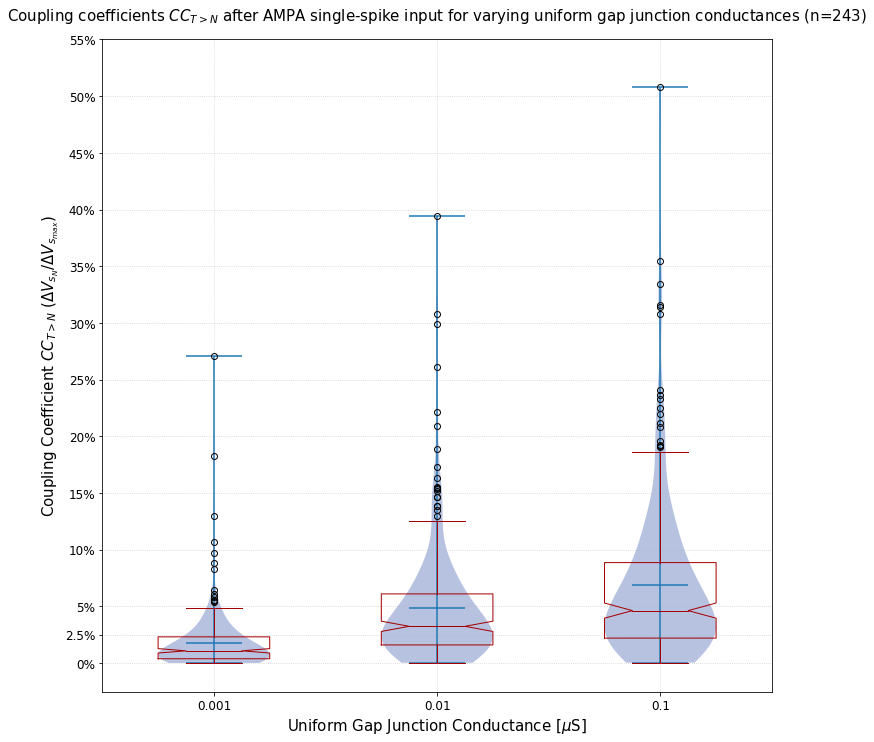

In [14]:
#Combining all Coupling coefficient values into one single list
cc_all = [x_001_mean.cc1, x_01_mean.cc1, x_1_mean.cc1]

#Plotting the violin plot
plt.figure(figsize = (12,12))
violin_parts = plt.violinplot(cc_all, vert=True,
                               widths=0.5, showmeans=True, showextrema=True,
                               showmedians=False,
                               bw_method=None, data=cc_all);
for pc in violin_parts['bodies']:
    pc.set_facecolor('#11389c')
    pc.set_alpha(0.3)

#Including a boxplot with quantiles
bp = plt.boxplot(cc_all, notch=True, widths = 0.5, patch_artist=False, meanline=False, showfliers = True)
# change the color of its elements
for _, line_list in bp.items():
    for line in line_list:
        line.set_color('#a50000')

#Additional settings 
plt.xticks(ticks = [1,2,3], labels = [0.001, 0.01, 0.1], fontsize = 12);
plt.yticks([0,2.5,5,10,15,20,25,30,35,40,45,50,55],['0%','2.5%','5%','10%', '15%', '20%', '25%', '30%', '35%', '40%','45%','50%', '55%'], fontsize = 12);
plt.ylabel(r'Coupling Coefficient $CC_{T>N}$ ($\Delta V_{s_{N}} / \Delta V_{s_{max}}$)', fontsize = 15);
plt.xlabel(r'Uniform Gap Junction Conductance [$\mu$S]', fontsize = 15);
plt.title(r'Coupling coefficients $CC_{T>N}$ after AMPA single-spike input for varying uniform gap junction conductances (n=243)', fontsize = 15, y =1.02)
plt.grid(True, alpha = 0.6, linestyle = 'dotted')

#Please do NOT do it here! But; 
#If you would like to save the image:
#plt.savefig('/home/cberns/Images/CC_data/cc1_vs_conductance.svg', format='svg', bbox_inches='tight')

## The distribution around the 0 axis of the Symmetry Coefficient (SC)
Next, as the SCs are also calculated using the enormous function which we used before, we can see what the SC distributions are along the $x$-axis which has its symmetry in zero. So if the coupling coefficient calculated from target to neighbour would be exactly similar to the CC when neighbour is spiked and the other direction is calculated, we would see a perfect symmetry in this mirroring line and it would also be very close to x=0 (with of course the potential for very small errors). As you can see below in the results, this is not the case. In some situations, the coupling coefficients differ so much that an (a)symmetry is observed of around 100-150. As we have concluded from the CC distributions in the previous codeblock and violin-plot, we will only start using the 0.01 $\mu$S UGJC-tuned network, as this is biologically the most relevant value. 

Mean is:
-3.532978541719468
Standard deviation is:
48.59337195001082


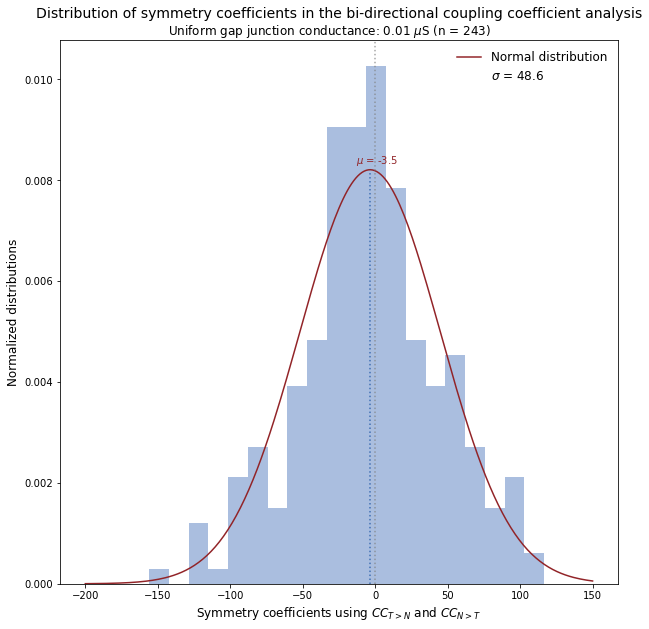

In [29]:
data = x_01_mean.Symmetry

plt.figure(figsize = (10,10))
hist,bins,_ = plt.hist(data, bins = 20, alpha = 0.6, density=True, stacked=True, color = '#7293CB')

# find minimum and maximum of xticks, so we know where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(data))

#Get a normal distribution and the right accompanying values
mu, sigma = stats.norm.fit(data) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, mu, sigma) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label='Normal distribution', color = '#922428') # plot it
plt.legend(frameon=False, fontsize = 12)
plt.axvline(x=0, color = 'grey', linestyle = 'dotted', alpha = 0.7)
plt.axvline(x = mu, alpha = 0.95, color = '#396AB1', linestyle = 'dotted', ymax = 0.76)
plt.text(mu-10, pdf_g.max()*1.015, r'$\mu$ = '+str(round(mu,1)), rotation=0, color = '#922428')
plt.text(80, 0.01, r'$\sigma$ = '+str(round(sigma,1)), rotation=0, color = 'k', fontsize = 12)
plt.title("Distribution of symmetry coefficients in the bi-directional coupling coefficient analysis", y = 1.03, fontsize = 14)
plt.suptitle("Uniform gap junction conductance: 0.01 $\mu$S (n = 243)", y = 0.905)
plt.xlabel("Symmetry coefficients using $CC_{T>N}$ and $CC_{N>T}$", fontsize = 12)
plt.ylabel("Normalized distributions", fontsize = 12)
#plt.savefig("/home/cberns/Images/Symmetry/CC_Large_distr_0_1.svg",format='svg', bbox_inches='tight')

print(str("Mean is:"))
print(mu)
print(str("Standard deviation is:")) 
print(sigma)

# Symmetry coefficient and potential parameters of influence

## Dendrite length and Symmetry 
As the segments of the dendrites simulated grow stochastically until they reach glomeruli and form gap junctions, the dendrites are of variable lengths. To determine whether the length has an impact on the conductance and, therefore,  the $\Delta V_s$, the $CC$s and the symmetry coefficient between the connected neurons, it was assessed if the symmetry coefficients were correlated to the dendrite length for the three UGJCs (for 8 initial target simulations and n=80 connecting neighbours / data points). If more data points would be included, it would get messy and therefore only the first 8 complete simulations are used. It was previously assumed that a larger dendrite length would correlate with a smaller coupling coefficient, as a longer dendrite would contain more leakage current towards the glomerulus of the neighbouring neuron. Therefore, the initial AMPA input would be conducted in a lesser manner, which would mean that the coupling coefficient would have to be inversely correlating with the dendritic length. Therefore, we will below see if this indeed is the case. 

## Changing plots
Similarly, you could plot this for $CC_2$ and the Symmetry coefficients. Just change the .cc1 to either .cc2 or .Symmetry and you have these plots as well. For the Symmetry coefficient vs dendrite lengths plot, I used an extra line of code to include a Symmetry axis around y = 0, see below.
 
for i in [0,1,2]:
    axs[i].axhline(y=0,xmin = 0,xmax = 500, linestyle = 'dotted', alpha = 0.4, color = 'red')

Text(0, 0.5, 'Coupling coefficient $CC_{T>N}$')

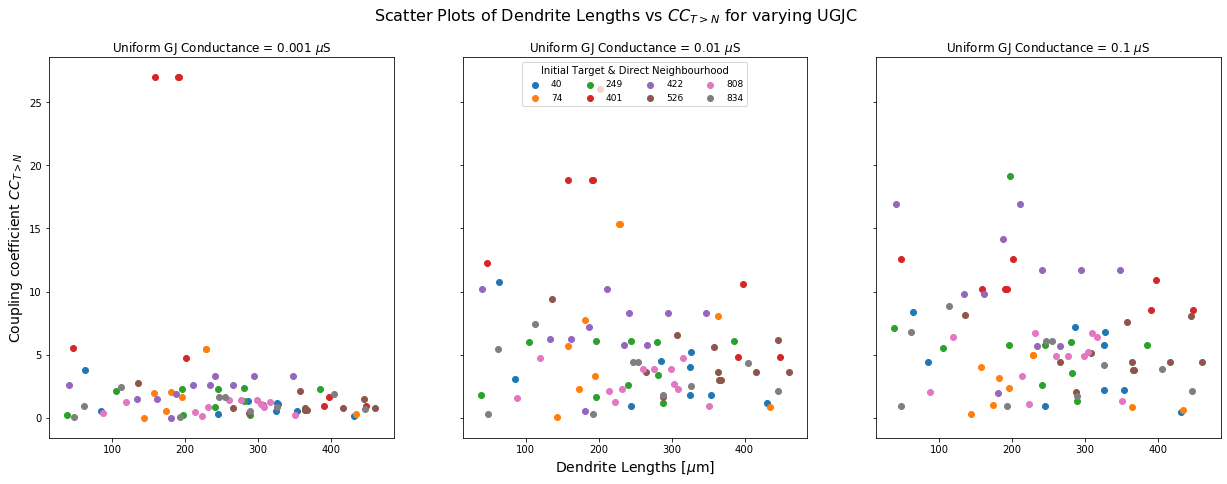

In [31]:
fig, axs = plt.subplots(1, 3, figsize = (21,7), sharey=True)
fig.suptitle('Scatter Plots of Dendrite Lengths vs $CC_{T>N}$ for varying UGJC', fontsize = 16)

newx001 = x_001[0:80]
newx01 = x_01[0:80]
newx1 = x_1[0:80]

for tid in sorted(set(newx001.spike_target_gid)):
    m = x_01.spike_target_gid == tid    
    axs[0].scatter(newx001.dend_length[m], newx001.cc1[m], label=str(tid))
    axs[1].scatter(newx01.dend_length[m], newx01.cc1[m], label=str(tid))
    axs[2].scatter(newx1.dend_length[m], newx1.cc1[m], label=str(tid))
    
axs[0].set_title('Uniform GJ Conductance = 0.001 $\mu$S')
axs[1].set_title('Uniform GJ Conductance = 0.01 $\mu$S')
axs[2].set_title('Uniform GJ Conductance = 0.1 $\mu$S')

axs[1].legend(ncol=4, loc="upper center", title = "Initial Target & Direct Neighbourhood", fontsize = 9)

axs[1].set_xlabel('Dendrite Lengths [$\mu$m]', fontsize = 14)
axs[0].set_ylabel('Coupling coefficient $CC_{T>N}$' , fontsize = 14)

## Average symmetry coefficient vs sum of dendrite length per initial spike target
To see if there was some sort of correlation in the total length of dendrites going out of a randomly selected (and spiked) neuron and the average symmetry coefficient between the target and its neighbours, you could plot the sum of these lengths against the mean of the SCs. This will be done in the code below, showing that there is no correlation which can be found. 

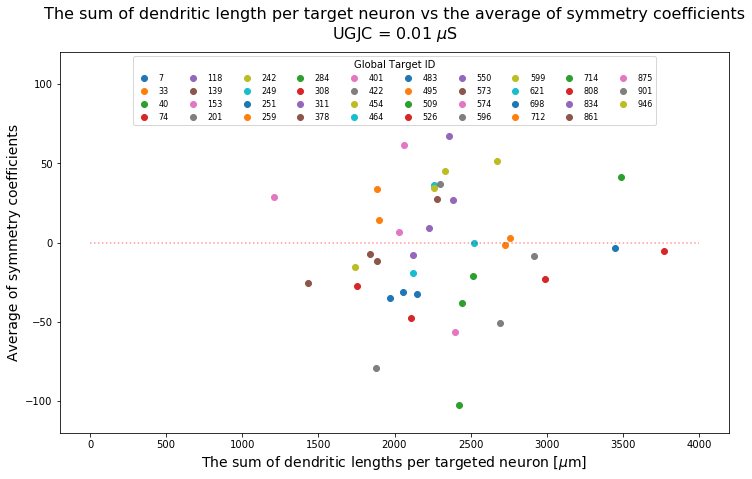

In [33]:
df = pd.DataFrame(x_01)
#Group all the values per target ID for UGJC = 0.01 uS
group_sum = df.groupby(by = "spike_target_gid").sum()
group_mean = df.groupby(by = "spike_target_gid").mean()

#Plot them in a scatterplot
plt.figure(figsize = (12,7))
for gid in group_mean.index: 
    m = group_mean.index == gid
    plt.scatter(x = group_sum.dend_length[m], y = group_mean.Symmetry[m], label = str(gid))
plt.title(f'The sum of dendritic length per target neuron vs the average of symmetry coefficients\nUGJC = 0.01 $\mu$S', fontsize = 16, y=1.02)
plt.xlabel('The sum of dendritic lengths per targeted neuron [$\mu$m]', fontsize = 14)
plt.ylabel('Average of symmetry coefficients', fontsize = 14)
plt.legend(ncol = 10, loc = "upper center", fontsize = 8, title='Global Target ID')
plt.ylim(-120,120)
plt.hlines(y=0,xmin = 0,xmax = 4000, linestyle = 'dotted', alpha = 0.4, color = 'red')

## Other parameters of influence
As we can observe from the above figures, no correlation between dendrite length and either coupling coefficient nor symmetry coefficient could be found (n.b. this has been checked using OLS regression and other statistical measures). Hence, we started looking at other parameters. First, we solely looked into Calcium Low-type values of the channels of a neuron as a measure for excitability. We found that there was no immediate correlation between these. Next, we introduced another parameter in order to better grasp the excitability of a neuron. This parameter has been briefly described above, before the enormous function, in the section "other parameters". To remind you, the input resistance (our measure for excitability) was: 

\begin{equation}
    R_{i} = \frac{max(\Delta V_s)}{V_{mean}}
    \label{eqn:inputR}
\end{equation}

After including all parameters we hypothesized may be of influence in the asymmetry observed previously, a heatmap of the piecewise correlations between the various parameters was created. Because it was easy enough, the other two UGJCs (0.001 and 0.1 were also included). There, we found that there indeed is a correlation. Namely, one that - for the UGJC of 0.01 $\mu$S - shows that the difference in input resistance is highly correlated with the symmetry coefficient (or difference in coupling coefficients). Furthermore, we do observe that the calcium low-type (CaL) level of the target (CaL_T) correlates in all cases significantly with the coupling coefficient $CC_2$ and the reverse for the CaL levels of the neighbour (CaL_N) influencing the $CC_1$ is true. This is to be expected as the CaL levels may influence the inductance of the neighbouring neuron. 

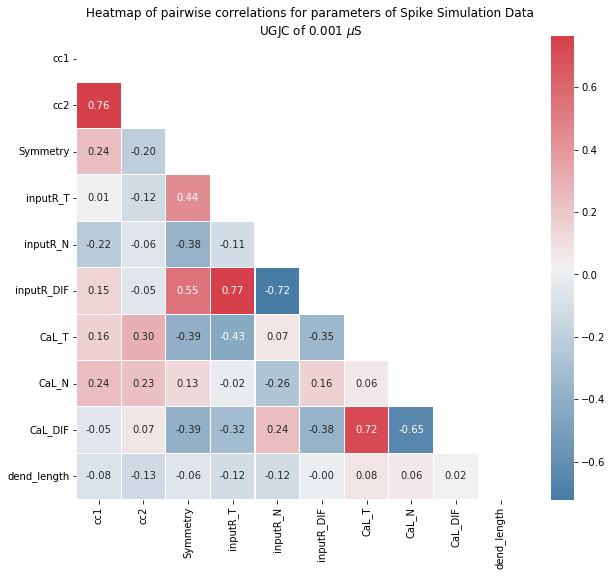

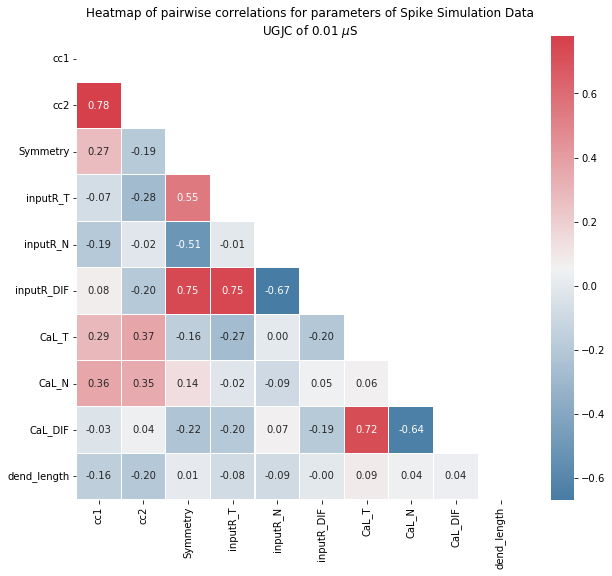

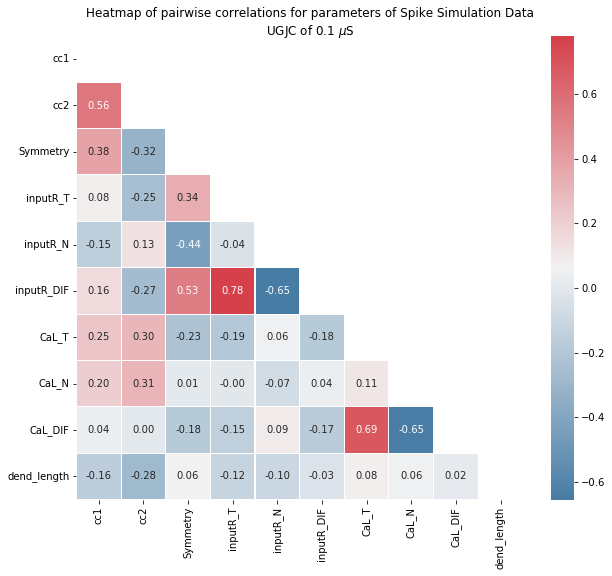

In [38]:
from statsmodels.stats.multitest import multipletests

#Naming the data frames in order to change the titles
x_001_mean.name = '0.001'
x_01_mean.name = '0.01'
x_1_mean.name = '0.1'

dfs = [x_001_mean, x_01_mean, x_1_mean]

#Looping per data frame
for df in dfs:
    #Using only parameters of interest
    xdata = df[
        [
         'cc1',
         'cc2',
         'Symmetry',
         'inputR_T',
         'inputR_N',
         'inputR_DIF',
         'CaL_T',
         'CaL_N',
         'CaL_DIF',
         'dend_length'
        ]
    ]
    
    #Starting the plot
    f,ax = plt.subplots(figsize=(10,8))
    corr = xdata.corr(method = 'pearson')
    pval = xdata.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.0005,0.005,0.05] if x<=t]))
    final = corr.round(2).astype(str) + p
    mask =np.triu(np.ones_like(corr,dtype=bool))
    
    hm = sns.heatmap(corr, annot=True,ax=ax, cmap=sns.diverging_palette(240, 10, n=9, s=70, l=50, as_cmap=True),
                     fmt='.2f', linewidths=0.05, mask = mask)
    f.subplots_adjust(top=0.93)
    t=f.suptitle('Heatmap of pairwise correlations for parameters of Spike Simulation Data\nUGJC of %s $\mu$S'%df.name, ha='center', x = 0.45)
    #plt.savefig('/home/cberns/Images/Symmetry/heatmap_cor_ALL_%s.svg'%df.name ,format='svg', bbox_inches='tight')

## Input resistance (excitability) vs Symmetry
As the IO network in the simulations done here do not have distinct values for all parameters and plasticity is not included in the weights of the connections, various parameters such as the UGJC, the time constants $\tau_1$ and $tau_2$ and the weight of the AMPA single-spike input are identical for different neurons. Therefore, the input current is linear to the sub-threshold oscillations of the membrane potential and the input resistance can be calculated relatively straightforward (see Methods of report). From above, the relation between the symmetry coefficient and the difference in excitability / input resistance between the two neurons seems to be apparent. First, the obtained values for these parameters were plotted in a scatter plot and coloured per UGJC, showing the distributions of data after running the code beow. Here, the relationship between the two parameters becomes evident and appears to be a linear directly proportional relation, particularly for the network tuned with a UGJC of $0.01 \mu$S. 

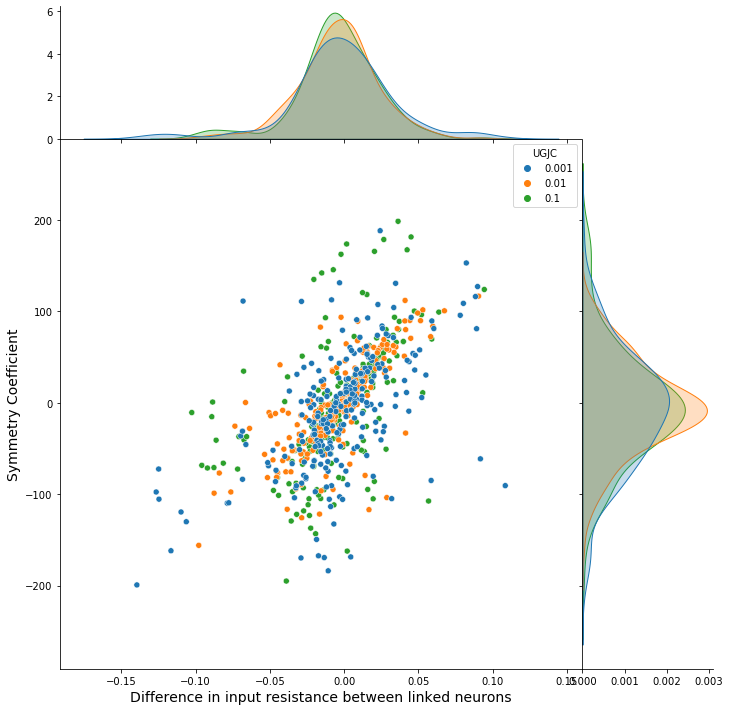

In [44]:
DF_mean = pd.concat([x_1_mean,x_01_mean,x_001_mean], ignore_index=True)

DF_data_mean = DF_mean[
    ['Symmetry',
     'inputR_DIF',
     'UGJC'   
    ]
]

#Something weird happened due to averaging, therefore twenty data point in the DF included a UGJC of ~ 0.100000001
#These are put back to the corresponding value of 0.1
DF_data_mean['UGJC'].values[DF_data_mean['UGJC'] > 0.1] = 0.1

g = sns.jointplot(x='inputR_DIF', y='Symmetry', data=DF_data_mean, kind ='scatter',
                space=0, height=10, ratio=4, marginal_ticks=True, hue = 'UGJC', palette=sns.color_palette(n_colors=3))
g.set_axis_labels('Difference in input resistance between linked neurons', 'Symmetry Coefficient', fontsize=14)




## Statistical Significance
To investigate if this is indeed the case here, an ordinary least squares regression (OLS) between the parameters including the coupling coefficients (to have a reference) is performed in the code below for the 0.01$\mu$S network in particular. The R-squared value is 0.761, which is this network containing a lot of non-linearity seems reasonable. Furthermore, the p-value and probability of the F-statistic are both much smaller than 0.05. The standard error of the linear coefficient for the input resistive difference, compared to the coefficient itself is rather small. Another statistic to understand if the coefficient is significant, is the $t$ in the OLS regression results, where a higher $t$ means that the coefficient is more significant. Therefore, the results shown in the plot above and after running the code below seem to suggest that it is a potentially linear relationship between the difference in excitability and the symmetry coefficient. Both the parameters contain the same directionality; postive when the parameter value is higher at the 'target' and negative in the other direction (neighbour gets perturbation). This indicates that the relationship is also directly proportional. N.B. For more info on how to use OLS and which variables should be included or what the outputs are, see https://www.statsmodels.org/stable/index.html.

In [ ]:
#Creating design matrices in order to process the fit, giving a dependent and 3 seemingly independent variables.
#y is the dependent variable, X is the array of independent variables.
y, X = dmatrices('Symmetry  ~  inputR_DIF + cc1 + cc2',
                 data = x_01_mean, return_type='dataframe')


#Describing the model using OLS on the design matrices
mod = sm.OLS(y,X)
#Fitting the model and obtaining results (pinv = Moore-Penrose pseudoinverse for solving, default and in this case the other option yields the same result).
res = mod.fit(method='pinv')
#Printing the model summary
print(res.summary())

#You can output many more interesting variables using for instance res.param
#For detailed description see text above for link on how to use statsmodels

#If you would like, like I wanted to create an .svg image of these results use below code:
#N.B. this also includes the pvalues of the different independent variables (!more precise, not 0.000!)
plt.rc('figure',figsize=(8,5))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.text(0.01, -0.15, str(res.pvalues[0:4]),{'fontsize': 10}, fontproperties = 'monospace')

#If you want to do some other correlation statistic tests, you could look into:

#print(scipy.stats.pearsonr(x_1_mean.Symmetry, x_1_mean.inputR_DIF))
#print(scipy.stats.spearmanr(x_01_mean.Symmetry, x_01_mean.inputR_DIF))
#print(scipy.stats.kendalltau(x_01_mean.Symmetry, x_01_mean.inputR_DIF))

## Calcium Low-type influence on excitability
To understand if there is a correlation between the excitability and the CaL parameter, one needs to create a space where the non-linear data can be linearly approximated. All different ion-channel options should be included in this analysis and in this parameter space, it may be possible to grasp the potential interrelation between CaL (and the other ion-channels) and the excitability / input resistance and, by that, the relation with asymmetry. However, as this is quite tedious to do and due to lack of time, here we just assessed the relationship in a linear fashion as above and plot this. Symmetry lines around both axes $x$ and $y$ = 0 were included to get a better insight into potential correlations. Unfortunately, no immediate correlation could be found. 

In [ ]:
#Excluding all the zero value rows for the CaL_DIF values (then, CaL_T and CaL_N are both zero and not of interest)
x_01_mean = x_01_mean[x_01_mean['CaL_DIF'] != 0 ]

#Creating a jointplot with scatter between difference in input resitance and diff in CaL levels
i = sns.jointplot(x='inputR_DIF', y='CaL_DIF', data=x_01_mean, kind ='scatter',
                space=0, height=10, ratio=4, marginal_ticks=False,
                 xlim=[-0.17,0.17], ylim=[-0.003,0.003])

#Adding symmetry lines around x=0 and y=0
i.ax_joint.axvline(x=0, alpha = 0.4, color = 'red', linestyle = 'dotted')
i.ax_joint.axhline(y=0, alpha = 0.4, color = 'red', linestyle = 'dotted')
i.set_axis_labels('Difference in input resistance between linked neurons', 'Difference in Calcium Low-Type levels', fontsize=14)
plt.savefig('/home/cberns/Images/Symmetry/InputR_DIFvsCaL_DIF.svg',format='svg',bbox_inches='tight')